In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn


In [2]:
%load_ext google.cloud.bigquery

# Data Preparation

**First: conversion REG**

In [3]:
%%bigquery ga_last_touch

WITH reg AS(
              SELECT 
                DISTINCT full_visitor_id, organization_uuid , country_id , 
                session_id , session_start_time , session_end_time ,
                traffic_source_level_1, traffic_source_level_2 , traffic_source_level_3, 
                RANK() OVER(PARTITION BY full_visitor_id ORDER BY session_start_time) AS rank_entry
              FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
              WHERE session_reached_minimal_page_visit IS True
              ORDER BY full_visitor_id , organization_uuid , session_start_time 
)
SELECT 
  reg.full_visitor_id ,
  reg.organization_uuid ,
  reg.country_id AS country_id_1,
  oc.country_id AS country_id_2,
  reg.session_id,
  reg.session_start_time ,
  reg.session_end_time ,
  oc.organization_created ,
  reg.traffic_source_level_1 ,
  reg.traffic_source_level_2 ,
  reg.traffic_source_level_3 
FROM reg
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON reg.organization_uuid = oc.organization_uuid
WHERE rank_entry = 1
AND ((oc.organization_created <= TIMESTAMP_ADD(session_end_time, INTERVAL 30 MINUTE) AND oc.organization_created >= session_start_time) OR organization_created IS NULL)
ORDER BY full_visitor_id , reg.session_start_time 

REG: only account created? Or after filling KYC form?

In [4]:
ga_last_touch.head()

,full_visitor_id,organization_uuid,country_id_1,country_id_2,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_1,traffic_source_level_2,traffic_source_level_3
0,1000007729674923752,None,FI,None,"b""\xb8\xe54^\xa5\xfb\xa5!\xb3_0V\x90J^\xa3,'\x...",2018-11-13 20:07:03+00:00,2018-11-13 20:07:58+00:00,NaT,online,o_paid,o_paid_affiliate
1,1000009529261921496,None,MX,None,"b""\xcb\xd8\x021\x11\xec'\xa3\x1eGM4\xca\xed\xf...",2018-09-25 01:52:26+00:00,2018-09-25 01:52:48+00:00,NaT,online,o_paid,o_paid_sem
2,1000010740411935385,f4e1d400-a89a-11e7-9f2a-dbfd5c91c102,BR,BR,b'\xec\x95\x05)\xd49\xef\xc4\xber\xee\x8a9\xa8...,2017-10-04 00:26:03+00:00,2017-10-04 00:29:33+00:00,2017-10-04 00:28:34.496000+00:00,online,o_paid,o_paid_social
3,1000015615247840995,None,MX,None,b'\xfc\xe0<\xc8+\xf9\x8e\xc4\t\xcer O\x95\x189...,2019-04-12 20:36:57+00:00,2019-04-12 20:36:57+00:00,NaT,online,o_organic,o_organic_direct
4,1000021533714909214,6c6f76cc-77dd-11e9-86cd-911ca4d20a09,NL,NL,"b'\xec\xb5\x9fd\xd8f\xd9\x9e\xd4\xf8\xf3""\x9e\...",2019-05-16 13:20:22+00:00,2019-05-16 14:04:04+00:00,2019-05-16 13:20:50.223000+00:00,online,o_organic,o_organic_seo


### Data exploration

In [5]:
ga_last_touch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382765 entries, 0 to 1382764
Data columns (total 11 columns):
full_visitor_id           1382765 non-null object
organization_uuid         252534 non-null object
country_id_1              1379951 non-null object
country_id_2              252534 non-null object
session_id                1382765 non-null object
session_start_time        1382765 non-null datetime64[ns, UTC]
session_end_time          1382765 non-null datetime64[ns, UTC]
organization_created      252534 non-null datetime64[ns, UTC]
traffic_source_level_1    1382765 non-null object
traffic_source_level_2    1382765 non-null object
traffic_source_level_3    1382765 non-null object
dtypes: datetime64[ns, UTC](3), object(8)
memory usage: 116.0+ MB


In [6]:
ga_last_touch[['full_visitor_id', 'organization_uuid']].nunique()

full_visitor_id      1382765
organization_uuid     252164
dtype: int64

organization_uuid: 251077 non-null object # organization_uuid: 250707 unique

-> duplicates in organization_uuid?

Question: why some full_visitor_id have no organization_uuid? When organization_uuid is created?

**Remove: multiple uuid -> one uuid**

In [7]:
last_touch_table = ga_last_touch.copy()

In [8]:
last_touch_table = last_touch_table.sort_values(by=['organization_uuid','session_start_time'])
last_touch_table['rank'] = last_touch_table.groupby('organization_uuid')['session_start_time'].rank()

In [9]:
def rank_na(df):
    for i in list(last_touch_table.index):
        if not df['organization_uuid'].loc[i]:
            df.at[i, 'rank'] = 1
        else: df['rank'].loc[i]
    #return df['rank']

In [10]:
rank_na(last_touch_table)

*Check rank of rows with NA values in organization_uuid to make sure the fuction correct*

In [11]:
last_touch_table[last_touch_table['organization_uuid'].isna()]

,full_visitor_id,organization_uuid,country_id_1,country_id_2,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_1,traffic_source_level_2,traffic_source_level_3,rank
41437,1247537097316742515,None,NL,None,"b""l\x99x?G\x8a'lv3\xf1_\x0et\x95\xedh\x05(\xf1""",2017-09-06 09:05:48+00:00,2017-09-06 09:35:27+00:00,NaT,online,o_organic,o_organic_seo,1.0
1311704,8876683833002197724,None,GB,None,b'JQzE\xc6\xf3G\x9a<\x7fy{C@\xff\x1e\x03\xf8\x...,2017-09-06 09:13:57+00:00,2017-09-06 09:13:57+00:00,NaT,online,o_organic,o_organic_invite,1.0
682543,5098077489811155899,None,SE,None,b'\xeanL\xaa\xf6\xc7\xce3iw\x82HY\xdcQ\xc5iW\x...,2017-09-06 09:14:37+00:00,2017-09-06 09:14:56+00:00,NaT,online,o_organic,o_organic_seo,1.0
608033,465131683917577424,None,SE,None,b'\xbd\x17\x17M\xcf\x81\x03B\x11Yw\xfb\x84\xb8...,2017-09-06 09:16:03+00:00,2017-09-06 09:16:53+00:00,NaT,online,o_organic,o_organic_seo,1.0
511634,4071522177981070551,None,DE,None,b'D=\xab$\xa3\xaaMO\xcd\xfan@q\xd9\x1a\xb4V\x8...,2017-09-06 09:16:07+00:00,2017-09-06 09:27:35+00:00,NaT,online,o_organic,o_organic_direct,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29269,117516740649190651,None,GB,None,b'4\xa8\xe8\xeet\x91(\xe6\x92\xc2e\x85\x07\x93...,2019-09-27 21:54:03+00:00,2019-09-27 21:59:58+00:00,NaT,online,o_organic,o_organic_direct,1.0
770769,5626270076858434852,None,FI,None,b'\xec\xab\xec)\xd11\x94\x97\xc4l\xe6\xde\xa9\...,2019-09-27 21:54:45+00:00,2019-09-27 21:58:18+00:00,NaT,online,o_paid,o_paid_sem,1.0
926069,6559738165891859765,None,MX,None,b'i\xb6\x82\x8e7\x1e\xca\xe1\xcd\x9b\xb4\x1f3=...,2019-09-27 21:55:01+00:00,2019-09-27 21:55:01+00:00,NaT,online,o_paid,o_paid_sem,1.0
11798,1070192116703855950,None,BR,None,b'\x03\x1c\x96\xe0\x0cT\xdb\xcd\x068\x81\x9bKJ...,2019-09-27 21:56:10+00:00,2019-09-27 21:57:51+00:00,NaT,online,o_paid,o_paid_sem,1.0


*Check rank of one obs with duplicates uuid to make sure the fuction correct*

In [13]:
last_touch_table[last_touch_table['organization_uuid'] == '0966d220-1058-11e8-803b-73c4d9ef05e9']

,full_visitor_id,organization_uuid,country_id_1,country_id_2,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_1,traffic_source_level_2,traffic_source_level_3,rank
934790,6613014701116896197,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\x0f\xef\xbech\xac\x98\x9b\xa4\xcf\x97E\xf8....,2018-02-13 00:39:49+00:00,2018-02-13 01:35:11+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,1.0
896963,6383219141733659615,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'z\xdd6\x0bH\x87\xe7\xf9p\xa3\xc3[=\xbe\x00\x...,2018-02-13 00:40:15+00:00,2018-02-13 01:19:50+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,2.0
1210657,8266483728897946580,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xc37\xc4\xbc(\x90tK\x07\x8c\xbe0dI\xb6\xd2....,2018-02-13 00:40:16+00:00,2018-02-13 00:58:50+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,3.0
592806,456033341175641039,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xb9\xc18\xcc\xdc\xb6\xedUF!\xe3D\x89\xf1X\x...,2018-02-13 00:40:17+00:00,2018-02-13 01:03:53+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,4.0
458970,3754605573539247079,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xb43\xc0\xeb\xd6s\nY\x17X\xe3\xe3\xca\xca\x...,2018-02-13 00:40:25+00:00,2018-02-13 00:58:32+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,5.0
270682,2621903838659095260,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xd9J\xf2:\xba\x82Q\xf8\xae\xa7\xb1\x04\xd8\...,2018-02-13 00:41:00+00:00,2018-02-13 01:06:26+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,6.0
275960,2653432059707667484,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,"b'c\x9b\xd4\xc1,e\x83\x99+rI\xce\xe9\xea9\xf7\...",2018-02-13 00:41:21+00:00,2018-02-13 01:46:32+00:00,2018-02-13 00:51:33.570000+00:00,online,o_paid,o_paid_sem,7.0
1061605,7374750670303409257,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\xf1\x13CLdneV\x1f\xdc<\\\xe5\xab\xe8\x04\x1...,2018-02-13 00:43:19+00:00,2018-02-13 01:31:15+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,8.0
445855,3676357733331907783,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\x1a\x85\xfcRAF>25<\xb9\xce\x0b\xe9\x00\x85\...,2018-02-13 00:44:25+00:00,2018-02-13 01:16:26+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,9.0
876553,6259130449856181559,0966d220-1058-11e8-803b-73c4d9ef05e9,MX,MX,b'\x93\x9f\xf7b\x06\x87.\x9e\xc3\xb2(\xb4\x87M...,2018-02-13 00:46:02+00:00,2018-02-13 01:31:19+00:00,2018-02-13 00:51:33.570000+00:00,online,o_organic,o_organic_direct,10.0


*Remove organization_uuids that have more than 1 record rows -> Keep only the first row*

In [14]:
last_touch_table_rm = last_touch_table[last_touch_table['rank'] == 1]

In [15]:
last_touch_table_rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382395 entries, 486946 to 886747
Data columns (total 12 columns):
full_visitor_id           1382395 non-null object
organization_uuid         252164 non-null object
country_id_1              1379581 non-null object
country_id_2              252164 non-null object
session_id                1382395 non-null object
session_start_time        1382395 non-null datetime64[ns, UTC]
session_end_time          1382395 non-null datetime64[ns, UTC]
organization_created      252164 non-null datetime64[ns, UTC]
traffic_source_level_1    1382395 non-null object
traffic_source_level_2    1382395 non-null object
traffic_source_level_3    1382395 non-null object
rank                      1382395 non-null float64
dtypes: datetime64[ns, UTC](3), float64(1), object(8)
memory usage: 137.1+ MB


In [16]:
last_touch_table_rm.head()

,full_visitor_id,organization_uuid,country_id_1,country_id_2,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_1,traffic_source_level_2,traffic_source_level_3,rank
486946,3922435973299981085,00003340-368a-11e8-812c-46c00ef89793,BR,BR,b'\x05A Bf\xaee\x1e|\x0c\t\xa97(\x7fp\x93[\xaf...,2018-04-02 15:23:56+00:00,2018-04-02 15:25:05+00:00,2018-04-02 15:24:56.820000+00:00,online,o_organic,o_organic_direct,1.0
528204,4172912977041397736,00003480-755a-11e8-941a-f4245c6e2118,GB,GB,b'\xa3\nUWK\xfb\xa5[ G\xfa\xac\xbd\x84\xb5\x10...,2018-06-21 13:48:29+00:00,2018-06-21 13:53:09+00:00,2018-06-21 13:50:04.232000+00:00,online,o_organic,o_organic_seo,1.0
458407,3751243344289626114,00004a10-0494-11e8-99f2-e8c819e6a9b3,FR,FR,b'n\x85\xbe\xd6\x8b\xc8D\xa3\xedu|e\xc6\x0cGa\...,2018-01-29 01:25:22+00:00,2018-01-29 03:01:20+00:00,2018-01-29 01:30:33.649000+00:00,online,o_paid,o_paid_affiliate,1.0
926219,6560746005688568793,0000e470-22df-11e8-b107-f6fb37cbda60,GB,GB,b'\xe9\t\xadt\xa3\xea\x00}\xd7\xc8\xd2\xc7F\x8...,2018-03-08 14:42:33+00:00,2018-03-08 14:57:03+00:00,2018-03-08 14:43:00.791000+00:00,online,o_organic,o_organic_direct,1.0
1357988,915369691078326946,00010590-496d-11e8-8276-f14429a1b395,GB,GB,b'\xe3\x15u\xcf\x88eKb)\x1e[\xa4\x03\xc8\x8ax9...,2018-04-26 16:13:22+00:00,2018-04-26 16:23:36+00:00,2018-04-26 16:15:13.513000+00:00,online,o_paid,o_paid_sem,1.0


**Regroup: traffic_source_3: partnership and direct**

Idea: 
- Traffic source level 3 for online channels: keep remain
- Traffic source level 3 for direct: group all in direct (level.1)
- Traffic source level 3 for partnerships: group all in partnerships (level.1)

In [17]:
last_touch_table_rm.traffic_source_level_3.unique()

array(['o_organic_direct', 'o_organic_seo', 'o_paid_affiliate',
       'o_paid_sem', 'ps_pay_sdk', 'o_paid_social', 'ps_product_api',
       'ds_keyaccount_keyaccount', 'o_organic_invite', 'ps_bank_bank',
       'ps_other_local_partnership', 'ps_other_partner',
       'o_organic_referral', 'o_organic_null', 'ds_inbound_inbound',
       'ds_keyaccount_sdk', 'o_paid_app_install'], dtype=object)

In [18]:
last_touch_table_rm.traffic_source_level_2.unique()

array(['o_organic', 'o_paid', 'ps_pay', 'ps_product', 'ds_keyaccount',
       'ps_bank', 'ps_other', 'ds_inbound'], dtype=object)

In [19]:
last_touch_table_rm.traffic_source_level_1.unique()

array(['online', 'partnerships', 'direct'], dtype=object)

Check: why no of organization_uuid in ga_data is around 250,707 or if by visittor_id 1,378,537 since 2017-09-01? Looker: 1,097,237 (after 2017-09)

Ways to register/ become a merchant of iZettle?

In [20]:
last_touch_table_rm['traffic_source'] = last_touch_table_rm['traffic_source_level_3']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    for i in list(df.index):
        if df.traffic_source_level_3.loc[i] in list(dict_channels.keys()):
            df.at[i,'traffic_source'] = dict_channels[df.traffic_source_level_3.loc[i]]   
    

In [22]:
map_value(last_touch_table_rm)

Check the transformed data table

In [23]:
last_touch_table_rm.head(20)

,full_visitor_id,organization_uuid,country_id_1,country_id_2,session_id,session_start_time,session_end_time,organization_created,traffic_source_level_1,traffic_source_level_2,traffic_source_level_3,rank,traffic_source
486946,3922435973299981085,00003340-368a-11e8-812c-46c00ef89793,BR,BR,b'\x05A Bf\xaee\x1e|\x0c\t\xa97(\x7fp\x93[\xaf...,2018-04-02 15:23:56+00:00,2018-04-02 15:25:05+00:00,2018-04-02 15:24:56.820000+00:00,online,o_organic,o_organic_direct,1.0,o_organic_direct
528204,4172912977041397736,00003480-755a-11e8-941a-f4245c6e2118,GB,GB,b'\xa3\nUWK\xfb\xa5[ G\xfa\xac\xbd\x84\xb5\x10...,2018-06-21 13:48:29+00:00,2018-06-21 13:53:09+00:00,2018-06-21 13:50:04.232000+00:00,online,o_organic,o_organic_seo,1.0,o_organic_seo
458407,3751243344289626114,00004a10-0494-11e8-99f2-e8c819e6a9b3,FR,FR,b'n\x85\xbe\xd6\x8b\xc8D\xa3\xedu|e\xc6\x0cGa\...,2018-01-29 01:25:22+00:00,2018-01-29 03:01:20+00:00,2018-01-29 01:30:33.649000+00:00,online,o_paid,o_paid_affiliate,1.0,o_paid_affiliate
926219,6560746005688568793,0000e470-22df-11e8-b107-f6fb37cbda60,GB,GB,b'\xe9\t\xadt\xa3\xea\x00}\xd7\xc8\xd2\xc7F\x8...,2018-03-08 14:42:33+00:00,2018-03-08 14:57:03+00:00,2018-03-08 14:43:00.791000+00:00,online,o_organic,o_organic_direct,1.0,o_organic_direct
1357988,915369691078326946,00010590-496d-11e8-8276-f14429a1b395,GB,GB,b'\xe3\x15u\xcf\x88eKb)\x1e[\xa4\x03\xc8\x8ax9...,2018-04-26 16:13:22+00:00,2018-04-26 16:23:36+00:00,2018-04-26 16:15:13.513000+00:00,online,o_paid,o_paid_sem,1.0,o_paid_sem
202224,2212237917929704723,00010d50-7cf9-11e8-ac45-825a5d5471de,MX,MX,b't<\x0cop8X\xba\xdd\xb7\xe5\xa018<\xe5-\xdex\...,2018-07-01 06:35:27+00:00,2018-07-01 07:39:45+00:00,2018-07-01 06:35:52.357000+00:00,online,o_organic,o_organic_direct,1.0,o_organic_direct
1198613,8194633392790367279,00015db0-a7dd-11e7-b56f-1409ed2e8ae6,MX,MX,b'\xe6\x12SA\xe0\x80\xb0}\xdeH\xa2p\x00\\!!\xf...,2017-10-03 01:47:28+00:00,2017-10-03 01:48:57+00:00,2017-10-03 01:48:48.779000+00:00,online,o_organic,o_organic_direct,1.0,o_organic_direct
915896,6498036382235466624,00017826-6033-11e9-9901-24f0c523d5de,GB,GB,b'8\xa2\xff\xdf:\x98\x83\x0b|\xb6O\xf8\xc7\xbd...,2019-04-16 10:31:40+00:00,2019-04-16 10:55:39+00:00,2019-04-16 10:32:57.120000+00:00,online,o_paid,o_paid_affiliate,1.0,o_paid_affiliate
1023821,7146605014025510587,00019960-5dc7-11e8-bc50-43fd94569593,GB,GB,b'\x1clV@\xdf\xc3\x8b\x9fO}l\xe5\xee\x9f\xe60\...,2018-05-22 13:44:28+00:00,2018-05-22 14:30:30+00:00,2018-05-22 13:49:51.478000+00:00,online,o_paid,o_paid_sem,1.0,o_paid_sem
1345737,9080397503400783693,0001a1f0-9cff-11e7-9b42-1cb5332d9603,FI,FI,b'\xd3\xc1<\xe2Y\xe3ZJw]\xa1e\xb1*Wp\x88\x19\x...,2017-09-19 05:53:13+00:00,2017-09-19 06:01:43+00:00,2017-09-19 05:54:28.879000+00:00,online,o_paid,o_paid_sem,1.0,o_paid_sem


In [24]:
last_touch_table_rm.traffic_source.unique()

array(['o_organic_direct', 'o_organic_seo', 'o_paid_affiliate',
       'o_paid_sem', 'partnerships', 'o_paid_social', 'direct',
       'o_organic_invite', 'o_organic_referral', 'o_organic_null',
       'o_paid_app_install'], dtype=object)

In [52]:
basetable = last_touch_table_rm[['full_visitor_id','organization_uuid','country_id_1','organization_created','traffic_source']]

# Last touch model

### Global

In [28]:
basetable['traffic_source'] = basetable['traffic_source'].astype('category')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
def last_touch(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = 'slateblue')
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()
    

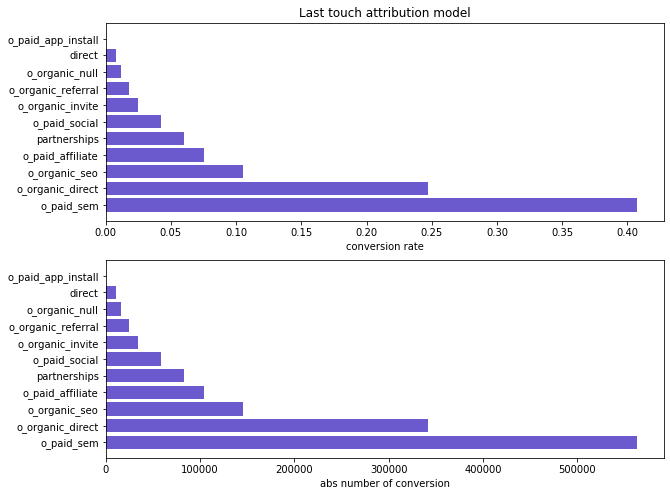

In [37]:
last_touch(basetable)

### Montly Basic

In [45]:
basetable_m = last_touch_table_rm[['full_visitor_id','organization_uuid','country_id_1','session_start_time','traffic_source']]

In [50]:
basetable_m['year_month'] = basetable_m.session_start_time.dt.to_period('M')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
basetable_m.head()

,full_visitor_id,organization_uuid,country_id_1,session_start_time,traffic_source,year_month
486946,3922435973299981085,00003340-368a-11e8-812c-46c00ef89793,BR,2018-04-02 15:23:56+00:00,o_organic_direct,2018-04
528204,4172912977041397736,00003480-755a-11e8-941a-f4245c6e2118,GB,2018-06-21 13:48:29+00:00,o_organic_seo,2018-06
458407,3751243344289626114,00004a10-0494-11e8-99f2-e8c819e6a9b3,FR,2018-01-29 01:25:22+00:00,o_paid_affiliate,2018-01
926219,6560746005688568793,0000e470-22df-11e8-b107-f6fb37cbda60,GB,2018-03-08 14:42:33+00:00,o_organic_direct,2018-03
1357988,915369691078326946,00010590-496d-11e8-8276-f14429a1b395,GB,2018-04-26 16:13:22+00:00,o_paid_sem,2018-04


In [ ]:
#not fix yet
def last_touch_monthly(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = 'slateblue')
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()

### By markets

### Markets and Monthly Basic